<a href="https://colab.research.google.com/github/aguilarmadeira/Optimization/blob/main/mollows_phi_variation_like_SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iteration 1, phi: 0.50, best distance: 3773.83
Iteration 2, phi: 0.51, best distance: 3773.83
Iteration 3, phi: 0.51, best distance: 3773.83
Iteration 4, phi: 0.52, best distance: 3661.44
Iteration 5, phi: 0.52, best distance: 3661.44
Iteration 6, phi: 0.52, best distance: 3582.24
Iteration 7, phi: 0.53, best distance: 3582.24
Iteration 8, phi: 0.53, best distance: 3504.82
Iteration 9, phi: 0.54, best distance: 3157.01
Iteration 10, phi: 0.54, best distance: 3157.01
Iteration 11, phi: 0.54, best distance: 3157.01
Iteration 12, phi: 0.55, best distance: 3157.01
Iteration 13, phi: 0.55, best distance: 3157.01
Iteration 14, phi: 0.56, best distance: 3157.01
Iteration 15, phi: 0.56, best distance: 3157.01
Iteration 16, phi: 0.56, best distance: 3157.01
Iteration 17, phi: 0.57, best distance: 3157.01
Iteration 18, phi: 0.57, best distance: 3157.01
Iteration 19, phi: 0.58, best distance: 3157.01
Iteration 20, phi: 0.58, best distance: 3157.01
Iteration 21, phi: 0.58, best distance: 3157.01
I

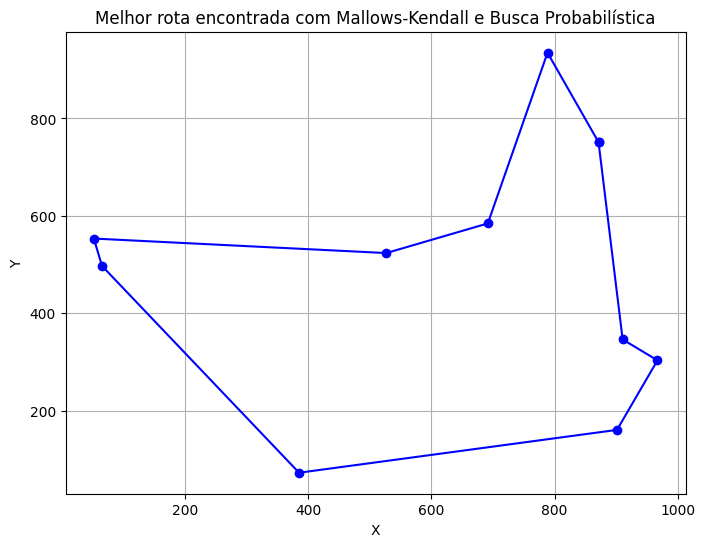

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import mallows_kendall as mk

# Classe representando uma cidade no TSP
class City:
    def __init__(self):
        self.x = np.random.uniform(0, 1000)
        self.y = np.random.uniform(0, 1000)

    def distance(self, city):
        return np.hypot(self.x - city.x, self.y - city.y)

# Classe para o problema TSP
class TSP:
    def __init__(self, num_cities):
        self.cities = [City() for _ in range(num_cities)]

    def tour_distance(self, perm):
        return sum(self.cities[perm[i]].distance(self.cities[perm[(i + 1) % len(perm)]]) for i in range(len(perm)))

# Classe usando Mallows-Kendall com busca probabilística e aceitação adaptativa (Metropolis)
class MallowsKendallTSP:
    def __init__(self, num_cities, phi_min=0.5, phi_max=0.9, m_samples=20, T0=1000):
        self.num_cities = num_cities
        self.phi_min = phi_min
        self.phi_max = phi_max
        self.m_samples = m_samples
        self.T0 = T0  # Temperatura inicial para Metropolis
        self.problem = TSP(num_cities)
        self.best_tour = np.random.permutation(num_cities)
        self.best_distance = self.problem.tour_distance(self.best_tour)

    # Critério de aceitação baseado no critério de Metropolis adaptado ao phi
    def accept_prob(self, current_distance, new_distance, phi):
        if new_distance < current_distance:
            return 1.0
        else:
            T_phi = self.T0 * (1 - phi)  # Temperatura adaptativa dependente do phi
            return np.exp(-(new_distance - current_distance) / T_phi)

    # Otimização com Mallows-Kendall e critério Metropolis adaptativo
    def optimize(self, iterations=100, p=1):
        current_tour = self.best_tour.copy()

        for iteration in range(iterations):
            # Ajuste dinâmico de phi
            phi = self.phi_min + (self.phi_max - self.phi_min) * ((iteration + 1) / iterations) ** p

            # Amostragem de soluções baseada no modelo de Mallows
            sampled_tours = mk.sample(m=self.m_samples, n=self.num_cities, phi=phi, s0=current_tour)

            for candidate in sampled_tours:
                candidate_distance = self.problem.tour_distance(candidate)
                acceptance_probability = self.accept_prob(self.best_distance, candidate_distance, phi)
                if np.random.rand() < acceptance_probability:
                    current_tour = candidate.copy()
                    if candidate_distance < self.best_distance:
                        self.best_distance = candidate_distance
                        self.best_tour = candidate.copy()

            print(f"Iteration {iteration + 1}, phi: {phi:.2f}, best distance: {self.best_distance:.2f}")

    def plot_solution(self):
        xs = [self.problem.cities[i].x for i in self.best_tour] + [self.problem.cities[self.best_tour[0]].x]
        ys = [self.problem.cities[i].y for i in self.best_tour] + [self.problem.cities[self.best_tour[0]].y]
        plt.figure(figsize=(8, 6))
        plt.plot(xs, ys, '-o', color='blue')
        plt.title('Melhor rota encontrada com Mallows-Kendall e Busca Probabilística')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid()
        plt.show()

# Exemplo de utilização
solver = MallowsKendallTSP(num_cities=10, phi_min=0.5, phi_max=0.9, m_samples=300, T0=1000)
solver.optimize(iterations=100)
solver.plot_solution()


Solving for 10 cities...
Solving for 20 cities...
Solving for 30 cities...
Solving for 40 cities...
Final solution found for 50 cities! Best distance: 4713.80


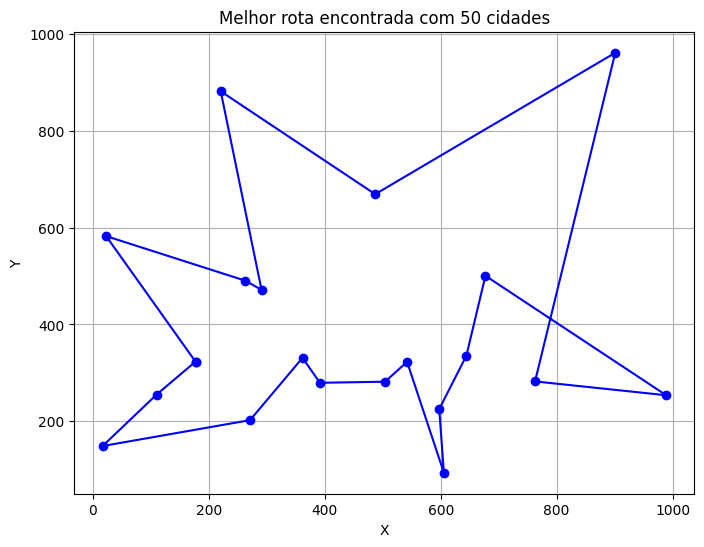

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import mallows_kendall as mk

# Classe representando uma cidade no TSP
class City:
    def __init__(self):
        self.x = np.random.uniform(0, 1000)
        self.y = np.random.uniform(0, 1000)

    def distance(self, city):
        return np.hypot(self.x - city.x, self.y - city.y)

# Classe para o problema TSP
class TSP:
    def __init__(self, num_cities):
        self.cities = [City() for _ in range(num_cities)]

    def tour_distance(self, perm):
        """ Calcula a distância total da rota """
        return sum(self.cities[perm[i]].distance(self.cities[perm[(i + 1) % len(perm)]]) for i in range(len(perm)))

    def best_insertion_position(self, tour, new_city):
        """ Encontra a melhor posição para inserir uma nova cidade na rota """
        best_position = 0
        min_cost_increase = float('inf')

        for i in range(len(tour)):
            prev_city = tour[i]
            next_city = tour[(i + 1) % len(tour)]  # Circular
            cost_increase = (
                self.cities[prev_city].distance(self.cities[new_city]) +
                self.cities[new_city].distance(self.cities[next_city]) -
                self.cities[prev_city].distance(self.cities[next_city])
            )

            if cost_increase < min_cost_increase:
                min_cost_increase = cost_increase
                best_position = i + 1  # Inserir depois de prev_city

        return best_position

# Classe usando Mallows-Kendall com inserção incremental
class MallowsKendallTSP:
    def __init__(self, total_cities, step=10, phi_min=0.5, phi_max=0.9, m_samples=20, T0=1000):
        self.total_cities = total_cities
        self.current_cities = step  # Começamos com 10 cidades
        self.step = step  # Quantas cidades adicionamos por vez
        self.phi_min = phi_min
        self.phi_max = phi_max
        self.m_samples = m_samples
        self.T0 = T0
        self.problem = TSP(total_cities)
        self.best_tour = np.random.permutation(self.current_cities)
        self.best_distance = self.problem.tour_distance(self.best_tour)

    def accept_prob(self, current_distance, new_distance, phi):
        """ Critério de Metropolis adaptado a phi """
        if new_distance < current_distance:
            return 1.0
        else:
            T_phi = self.T0 * (1 - phi)
            return np.exp(-(new_distance - current_distance) / T_phi)

    def optimize(self, iterations=100, p=1):
        """ Otimização iterativa do TSP com adição incremental de cidades """
        current_tour = self.best_tour.copy()

        while self.current_cities < self.total_cities:
            print(f"Solving for {self.current_cities} cities...")

            for iteration in range(iterations):
                phi = self.phi_min + (self.phi_max - self.phi_min) * ((iteration + 1) / iterations) ** p
                sampled_tours = mk.sample(m=self.m_samples, n=self.current_cities, phi=phi, s0=current_tour)

                for candidate in sampled_tours:
                    candidate_distance = self.problem.tour_distance(candidate)
                    acceptance_probability = self.accept_prob(self.best_distance, candidate_distance, phi)
                    if np.random.rand() < acceptance_probability:
                        current_tour = candidate.copy()
                        if candidate_distance < self.best_distance:
                            self.best_distance = candidate_distance
                            self.best_tour = candidate.copy()

            # Adicionamos mais cidades e as inserimos inteligentemente na solução atual
            num_new_cities = min(self.step, self.total_cities - self.current_cities)
            for _ in range(num_new_cities):
                new_city = self.current_cities
                best_pos = self.problem.best_insertion_position(self.best_tour, new_city)
                self.best_tour = np.insert(self.best_tour, best_pos, new_city)  # Insere na posição ótima
                self.current_cities += 1

            self.best_distance = self.problem.tour_distance(self.best_tour)  # Atualiza distância da melhor solução

        print(f"Final solution found for {self.total_cities} cities! Best distance: {self.best_distance:.2f}")

    def plot_solution(self):
        """ Plota a melhor rota encontrada """
        xs = [self.problem.cities[i].x for i in self.best_tour] + [self.problem.cities[self.best_tour[0]].x]
        ys = [self.problem.cities[i].y for i in self.best_tour] + [self.problem.cities[self.best_tour[0]].y]
        plt.figure(figsize=(8, 6))
        plt.plot(xs, ys, '-o', color='blue')
        plt.title(f'Melhor rota encontrada com {self.total_cities} cidades')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid()
        plt.show()

# Exemplo de utilização
solver = MallowsKendallTSP(total_cities=50, step=10, phi_min=0.5, phi_max=0.9, m_samples=300, T0=1000)
solver.optimize(iterations=100)
solver.plot_solution()


Solving for 10 cities...
Solving for 20 cities...
Solving for 30 cities...
Solving for 40 cities...
Final solution found for 50 cities! Best distance: 6408.67


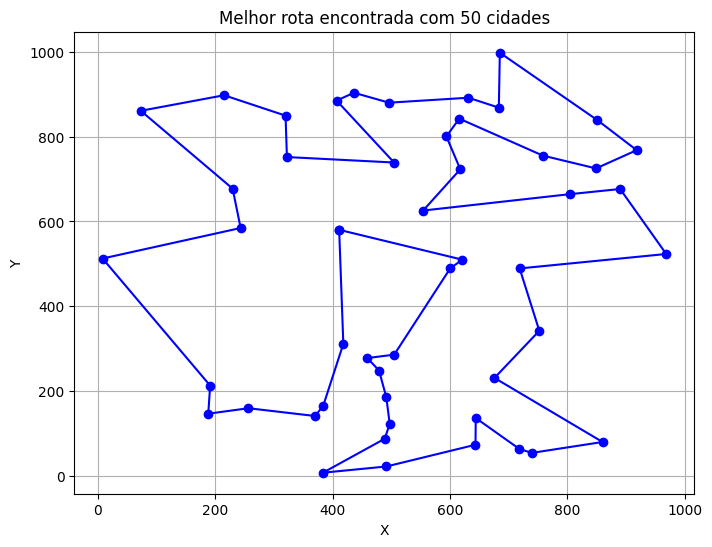

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import mallows_kendall as mk

# Classe representando uma cidade no TSP
class City:
    def __init__(self):
        self.x = np.random.uniform(0, 1000)
        self.y = np.random.uniform(0, 1000)

    def distance(self, city):
        return np.hypot(self.x - city.x, self.y - city.y)

# Classe para o problema TSP
class TSP:
    def __init__(self, num_cities):
        self.cities = [City() for _ in range(num_cities)]

    def tour_distance(self, perm):
        return sum(self.cities[perm[i]].distance(self.cities[perm[(i + 1) % len(perm)]]) for i in range(len(perm)))

    def most_distant_cities(self, num_selected=10):
        """Seleciona as cidades mais afastadas umas das outras para iniciar a solução."""
        selected_cities = [np.random.randint(len(self.cities))]  # Escolhe a primeira cidade aleatória

        while len(selected_cities) < num_selected:
            max_dist = -1
            farthest_city = None
            for i in range(len(self.cities)):
                if i in selected_cities:
                    continue
                min_dist = min(self.cities[i].distance(self.cities[j]) for j in selected_cities)
                if min_dist > max_dist:
                    max_dist = min_dist
                    farthest_city = i
            selected_cities.append(farthest_city)

        return np.array(selected_cities)

    def best_insertion_position(self, tour, new_city):
        """Encontra a melhor posição para inserir uma nova cidade na rota."""
        best_position = 0
        min_cost_increase = float('inf')

        for i in range(len(tour)):
            prev_city = tour[i]
            next_city = tour[(i + 1) % len(tour)]
            cost_increase = (
                self.cities[prev_city].distance(self.cities[new_city]) +
                self.cities[new_city].distance(self.cities[next_city]) -
                self.cities[prev_city].distance(self.cities[next_city])
            )

            if cost_increase < min_cost_increase:
                min_cost_increase = cost_increase
                best_position = i + 1  # Inserir depois de prev_city

        return best_position

# Classe usando Mallows-Kendall com inserção incremental
class MallowsKendallTSP:
    def __init__(self, total_cities, step=10, phi_min=0.5, phi_max=0.9, m_samples=20, T0=1000):
        self.total_cities = total_cities
        self.current_cities = step
        self.step = step
        self.phi_min = phi_min
        self.phi_max = phi_max
        self.m_samples = m_samples
        self.T0 = T0
        self.problem = TSP(total_cities)

        # Inicialização com as cidades mais afastadas
        self.best_tour = self.problem.most_distant_cities(num_selected=step)
        self.best_distance = self.problem.tour_distance(self.best_tour)

    def accept_prob(self, current_distance, new_distance, phi):
        """Critério de Metropolis adaptado a phi."""
        if new_distance < current_distance:
            return 1.0
        else:
            T_phi = self.T0 * (1 - phi)
            return np.exp(-(new_distance - current_distance) / T_phi)

    def optimize(self, iterations=100, p=1):
        """Otimização iterativa do TSP com adição incremental de cidades."""
        while self.current_cities < self.total_cities:
            print(f"Solving for {self.current_cities} cities...")

            for iteration in range(iterations):
                phi = self.phi_min + (self.phi_max - self.phi_min) * ((iteration + 1) / iterations) ** p

                # Atualizar s0 corretamente
                s0 = np.argsort(self.best_tour)  # Atualizamos para incluir todas as cidades processadas

                sampled_tours = mk.sample(
                    m=self.m_samples,
                    n=self.current_cities,  # Garantir que o tamanho esteja correto
                    phi=phi,
                    s0=s0
                )

                for candidate in sampled_tours:
                    candidate_distance = self.problem.tour_distance(candidate)
                    acceptance_probability = self.accept_prob(self.best_distance, candidate_distance, phi)
                    if np.random.rand() < acceptance_probability:
                        self.best_tour = candidate.copy()
                        self.best_distance = candidate_distance

            # Adicionar novas cidades e atualizar a solução
            num_new_cities = min(self.step, self.total_cities - self.current_cities)
            for _ in range(num_new_cities):
                new_city = self.current_cities
                best_pos = self.problem.best_insertion_position(self.best_tour, new_city)
                self.best_tour = np.insert(self.best_tour, best_pos, new_city)
                self.current_cities += 1

            self.best_distance = self.problem.tour_distance(self.best_tour)

        print(f"Final solution found for {self.total_cities} cities! Best distance: {self.best_distance:.2f}")

    def plot_solution(self):
        """Plota a melhor rota encontrada."""
        if len(self.best_tour) != self.total_cities:
            print("Erro: Nem todas as cidades foram adicionadas corretamente!")
            return

        xs = [self.problem.cities[i].x for i in self.best_tour] + [self.problem.cities[self.best_tour[0]].x]
        ys = [self.problem.cities[i].y for i in self.best_tour] + [self.problem.cities[self.best_tour[0]].y]
        plt.figure(figsize=(8, 6))
        plt.plot(xs, ys, '-o', color='blue')
        plt.title(f'Melhor rota encontrada com {self.total_cities} cidades')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid()
        plt.show()

# Exemplo de utilização
solver = MallowsKendallTSP(total_cities=50, step=10, phi_min=0.5, phi_max=0.9, m_samples=300, T0=1000)
solver.optimize(iterations=100)
solver.plot_solution()


Solving for 10 cities...


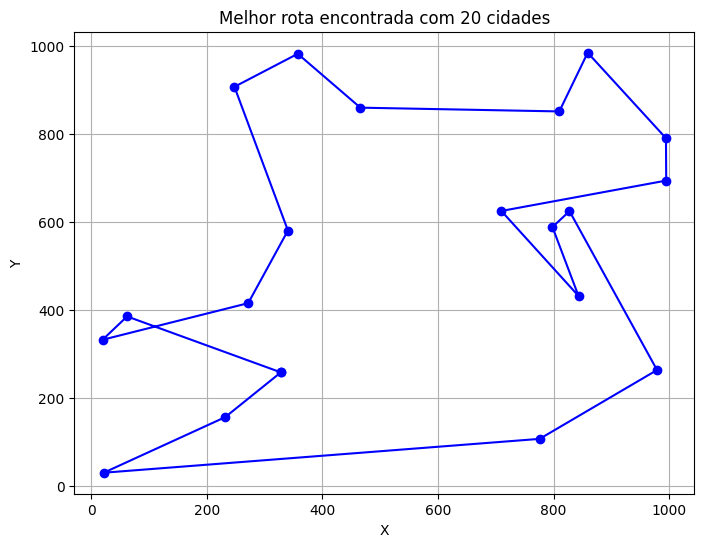

Solving for 20 cities...


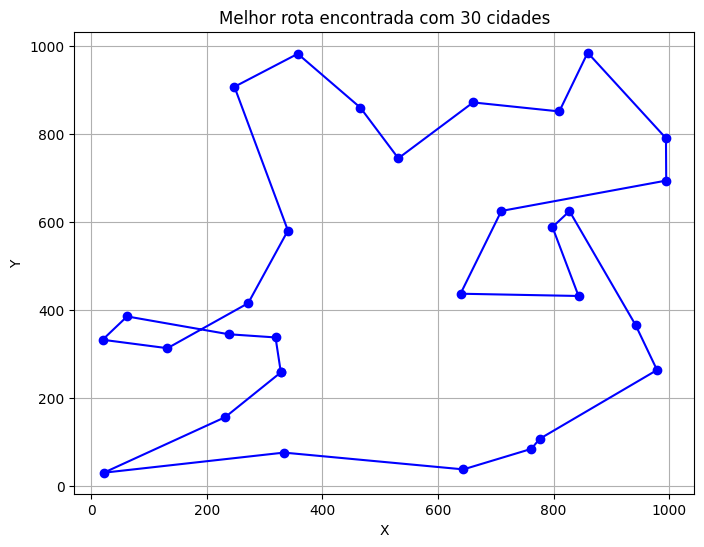

Solving for 30 cities...


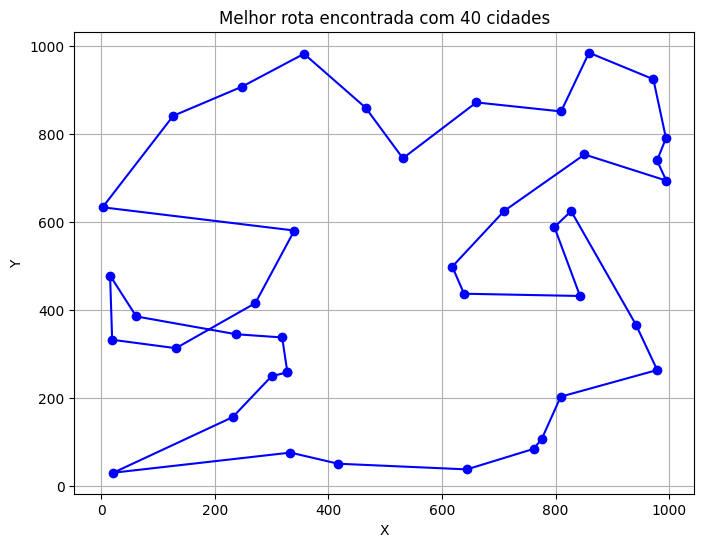

Solving for 40 cities...


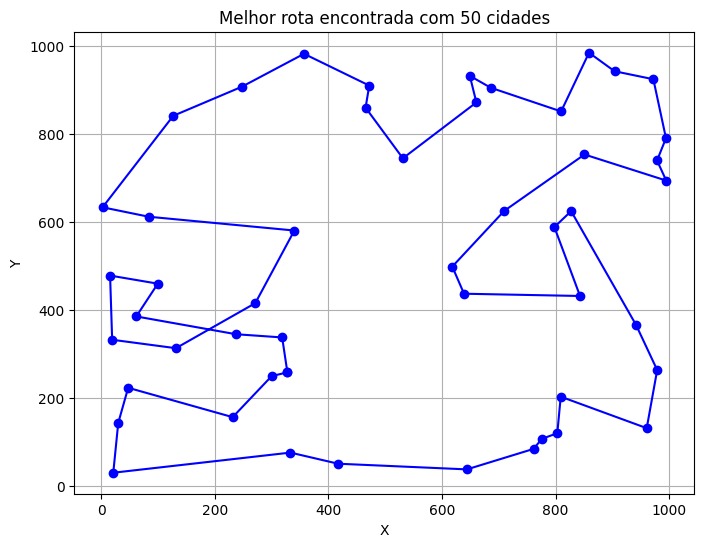

Final solution found for 50 cities! Best distance: 6340.50


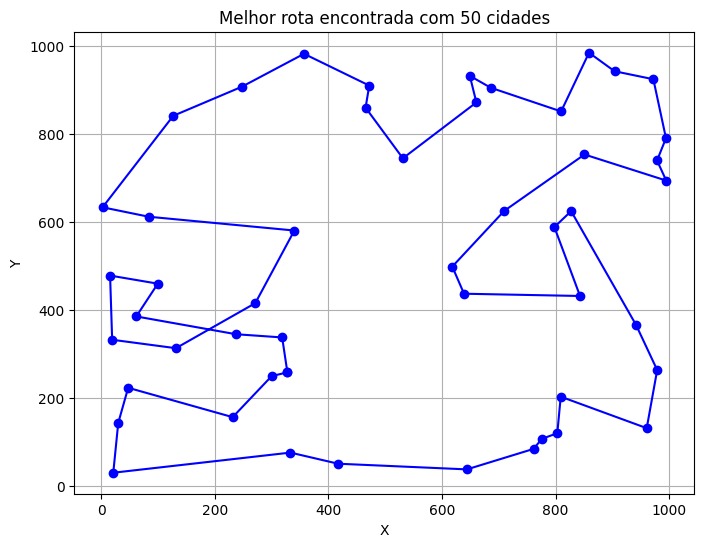

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import mallows_kendall as mk

# Classe representando uma cidade no TSP
class City:
    def __init__(self):
        self.x = np.random.uniform(0, 1000)
        self.y = np.random.uniform(0, 1000)

    def distance(self, city):
        return np.hypot(self.x - city.x, self.y - city.y)

# Classe para o problema TSP
class TSP:
    def __init__(self, num_cities):
        self.cities = [City() for _ in range(num_cities)]

    def tour_distance(self, perm):
        return sum(self.cities[perm[i]].distance(self.cities[perm[(i + 1) % len(perm)]]) for i in range(len(perm)))

    def most_distant_cities(self, num_selected=10):
        """Seleciona as cidades mais afastadas umas das outras para iniciar a solução."""
        selected_cities = [np.random.randint(len(self.cities))]  # Escolhe a primeira cidade aleatória

        while len(selected_cities) < num_selected:
            max_dist = -1
            farthest_city = None
            for i in range(len(self.cities)):
                if i in selected_cities:
                    continue
                min_dist = min(self.cities[i].distance(self.cities[j]) for j in selected_cities)
                if min_dist > max_dist:
                    max_dist = min_dist
                    farthest_city = i
            selected_cities.append(farthest_city)

        return np.array(selected_cities)

    def best_insertion_position(self, tour, new_city):
        """Encontra a melhor posição para inserir uma nova cidade na rota."""
        best_position = 0
        min_cost_increase = float('inf')

        for i in range(len(tour)):
            prev_city = tour[i]
            next_city = tour[(i + 1) % len(tour)]
            cost_increase = (
                self.cities[prev_city].distance(self.cities[new_city]) +
                self.cities[new_city].distance(self.cities[next_city]) -
                self.cities[prev_city].distance(self.cities[next_city])
            )

            if cost_increase < min_cost_increase:
                min_cost_increase = cost_increase
                best_position = i + 1  # Inserir depois de prev_city

        return best_position

# Classe usando Mallows-Kendall com inserção incremental e visualização
class MallowsKendallTSP:
    def __init__(self, total_cities, step=10, phi_min=0.5, phi_max=0.9, m_samples=20, T0=1000):
        self.total_cities = total_cities
        self.current_cities = step
        self.step = step
        self.phi_min = phi_min
        self.phi_max = phi_max
        self.m_samples = m_samples
        self.T0 = T0
        self.problem = TSP(total_cities)

        # Inicialização com as cidades mais afastadas
        self.best_tour = self.problem.most_distant_cities(num_selected=step)
        self.best_distance = self.problem.tour_distance(self.best_tour)

    def accept_prob(self, current_distance, new_distance, phi):
        """Critério de Metropolis adaptado a phi."""
        if new_distance < current_distance:
            return 1.0
        else:
            T_phi = self.T0 * (1 - phi)
            return np.exp(-(new_distance - current_distance) / T_phi)

    def optimize(self, iterations=100, p=1):
        """Otimização iterativa do TSP com adição incremental de cidades."""
        while self.current_cities < self.total_cities:
            print(f"Solving for {self.current_cities} cities...")

            for iteration in range(iterations):
                phi = self.phi_min + (self.phi_max - self.phi_min) * ((iteration + 1) / iterations) ** p

                # Atualizar s0 corretamente
                s0 = np.argsort(self.best_tour)  # Atualizamos para incluir todas as cidades processadas

                sampled_tours = mk.sample(
                    m=self.m_samples,
                    n=self.current_cities,  # Garantir que o tamanho esteja correto
                    phi=phi,
                    s0=s0
                )

                for candidate in sampled_tours:
                    candidate_distance = self.problem.tour_distance(candidate)
                    acceptance_probability = self.accept_prob(self.best_distance, candidate_distance, phi)
                    if np.random.rand() < acceptance_probability:
                        self.best_tour = candidate.copy()
                        self.best_distance = candidate_distance

            # Adicionar novas cidades e atualizar a solução
            num_new_cities = min(self.step, self.total_cities - self.current_cities)
            for _ in range(num_new_cities):
                new_city = self.current_cities
                best_pos = self.problem.best_insertion_position(self.best_tour, new_city)
                self.best_tour = np.insert(self.best_tour, best_pos, new_city)
                self.current_cities += 1

            self.best_distance = self.problem.tour_distance(self.best_tour)

            # Mostrar a solução a cada incremento
            self.plot_solution()

        print(f"Final solution found for {self.total_cities} cities! Best distance: {self.best_distance:.2f}")

    def plot_solution(self):
        """Plota a melhor rota encontrada."""
        if len(self.best_tour) != self.current_cities:
            print("Erro: Nem todas as cidades foram adicionadas corretamente!")
            return

        plt.figure(figsize=(8, 6))
        plt.clf()  # Limpar a figura anterior
        xs = [self.problem.cities[i].x for i in self.best_tour] + [self.problem.cities[self.best_tour[0]].x]
        ys = [self.problem.cities[i].y for i in self.best_tour] + [self.problem.cities[self.best_tour[0]].y]
        plt.plot(xs, ys, '-o', color='blue')
        plt.title(f'Melhor rota encontrada com {self.current_cities} cidades')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid()
        plt.pause(1)  # Pequena pausa para visualizar antes de continuar
        plt.show(block=False)  # Exibir sem interromper a execução

# Exemplo de utilização
solver = MallowsKendallTSP(total_cities=50, step=10, phi_min=0.5, phi_max=0.9, m_samples=300, T0=1000)
solver.optimize(iterations=100)
solver.plot_solution()
